# Preparation

In [1]:
import sys
sys.version

from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 

['/device:CPU:0', '/device:XLA_CPU:0', '/device:XLA_GPU:0']


In [4]:
import datetime
import time
from typing import List, Union

import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_datasets as tfds
from unidecode import unidecode

from util.tokenizer import Tokenizer

%load_ext tensorboard

In [5]:
print('Version:', tf.__version__)
print('Eager mode:', tf.executing_eagerly())
print('Is built with cuda?', tf.test.is_built_with_cuda())
print('Is built with gpu support?', tf.test.is_built_with_gpu_support())

print('Devices list:')
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices())

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Version: 2.3.0
Eager mode: True
Is built with cuda? True
Is built with gpu support? True
Devices list:
['/device:CPU:0', '/device:XLA_CPU:0', '/device:XLA_GPU:0']
Num GPUs Available:  0


# Data Load

In [6]:
imdb_reviews, info = tfds.load('imdb_reviews', with_info=True)
# ds = ds.shuffle(1024).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

print('Label info:')
print(info.features["label"].num_classes)
print(info.features["label"].names)
print(info.features["label"].int2str(0))  # Human readable version (8 -> 'cat')
print(info.features["label"].str2int('pos'))

print()
print('Feature info:')
print(info.features.shape)
print(info.features.dtype)
print(info.features['text'].shape)
print(info.features['text'].dtype)

print()
print('Datasplit info:')
print(info.splits.keys())
print(info.splits['train'].num_examples)
print(info.splits['train'].filenames)
print(info.splits['train'].num_shards)

Label info:
2
['neg', 'pos']
neg
1

Feature info:
{'text': (), 'label': ()}
{'text': tf.string, 'label': tf.int64}
()
<dtype: 'string'>

Datasplit info:
dict_keys(['test', 'train', 'unsupervised'])
25000
['imdb_reviews-train.tfrecord-00000-of-00001']
1


In [7]:
SPLIT_PERCENT = 80

imdb_train = tfds.load('imdb_reviews', split=f'train[:{SPLIT_PERCENT}%]', as_supervised=True)
imdb_val = tfds.load('imdb_reviews', split=f'train[{SPLIT_PERCENT}%:]', as_supervised=True)
imdb_test = tfds.load('imdb_reviews', split='test', as_supervised=True)

print(len(imdb_train))
print(len(imdb_val))
print(len(imdb_test))

20000
5000
25000


# Preprocessing Functions

In [125]:
STOPWORDS = stopwords.words('english')
STOPWORD_EXCEPTIONS = ['not', 'nor',  'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
for exception in STOPWORD_EXCEPTIONS:
    STOPWORDS.remove(exception)
    
def remove_stopwords(text: Union[str, List[str]]):
    if isinstance(text, str):
        tokenized_text = []
        for token in text.split():
            if token not in STOPWORDS: tokenized_text.append(token)
        return ' '.join(tokenized_text)
    else:
        i = 0
        tokenized_text = text
        while i < len(tokenized_text):
            if tokenized_text[i] in STOPWORDS:
                tokenized_text.pop(i)
            else:
                i += 1
        return tokenized_text

# Data Analysis

In [18]:
for elm in imdb_train.take(2):
    text, label = elm
    print('Text:', text)
    print('Label:', label)
    print()

Text: tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
Label: tf.Tensor(0, shape=(), dtype=int64)

Text: tf.Tensor(b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten

In [19]:
print('Train')
train_text = []
train_label = []
for text, label in tfds.as_numpy(imdb_train):
    train_text.append(text.decode('utf-8'))
    train_label.append(label)
train_text = np.array(train_text)
train_label = np.array(train_label)
print(train_text.shape)
print(train_label.shape)

print('Val')
val_text = []
val_label = []
for text, label in tfds.as_numpy(imdb_val):
    val_text.append(text.decode('utf-8'))
    val_label.append(label)
val_text = np.array(val_text)
val_label = np.array(val_label)
print(val_text.shape)
print(val_label.shape)

print('Test')
test_text = []
test_label = []
for text, label in tfds.as_numpy(imdb_test):
    test_text.append(text.decode('utf-8'))
    test_label.append(label)
test_text = np.array(test_text)
test_label = np.array(test_label)
print(test_text.shape)
print(test_label.shape)

pd_train = pd.DataFrame(np.array([train_text, train_label]).T, columns=['text', 'label'])
pd_val = pd.DataFrame(np.array([val_text, val_label]).T, columns=['text', 'label'])
pd_test = pd.DataFrame(np.array([test_text, test_label]).T, columns=['text', 'label'])

tok = Tokenizer()
pd_train['approx_length'] = pd_train['text'].apply(lambda x: len(remove_stopwords(tok.tokenize(x))))
pd_val['approx_length'] = pd_val['text'].apply(lambda x: len(remove_stopwords(tok.tokenize(x))))
pd_test['approx_length'] = pd_test['text'].apply(lambda x: len(remove_stopwords(tok.tokenize(x))))

Train
(20000,)
(20000,)
Val
(5000,)
(5000,)
Test
(25000,)
(25000,)


In [47]:
print('Train')
print(pd_train.describe(), end='\n\n')
print(pd_train['label'].describe(), end='\n\n')
print('Val')
print(pd_val.describe(), end='\n\n')
print(pd_val['label'].describe(), end='\n\n')
print('Test')
print(pd_test.describe())
print(pd_test['label'].describe(), end='\n\n')

Train
       approx_length
count    20000.00000
mean       180.15745
std        135.59529
min          6.00000
25%         95.00000
50%        134.00000
75%        222.00000
max       1822.00000

count     20000
unique        2
top           0
freq      10031
Name: label, dtype: object

Val
       approx_length
count    5000.000000
mean      179.830400
std       135.212639
min         8.000000
25%        94.000000
50%       134.000000
75%       221.000000
max      1481.000000

count     5000
unique       2
top          1
freq      2531
Name: label, dtype: object

Test
       approx_length
count   25000.000000
mean      176.235880
std       132.430367
min         6.000000
25%        93.000000
50%       132.000000
75%       216.000000
max      1837.000000
count     25000
unique        2
top           0
freq      12500
Name: label, dtype: object



# Train Tokenizer

In [52]:
VOCAB_SIZE = 50000

tokenizer = Tokenizer(VOCAB_SIZE)

sentences = []
for text_tensor, _ in imdb_train:
    sentences.append(text_tensor.numpy().decode('utf-8'))
start_time = time.time()
tokenizer.train_tokenizer(sentences)
print('Tokenizer train time:', time.time() - start_time)

FINAL_N_VOCAB = tokenizer.n_words
print(f'n_vocab: {FINAL_N_VOCAB}')

for text_tensor, _ in imdb_train.take(1):
    print(tokenizer.tokenize(text_tensor.numpy().decode('utf-8')))
    encoded = tokenizer.encode([text_tensor.numpy().decode('utf-8')])
    print(encoded)
    print('Encoded length:', len(encoded[0]))
    decoded = tokenizer.decode(encoded)
    print(decoded)

Least frequent words will be removed until n_vocab = 50000 (excluding special tokens)
Tokenizer train time: 3.886136293411255
n_vocab: 50004
['This', 'was', 'an', 'absolutely', 'terrible', 'movie', '.', "Don't", 'be', 'lured', 'in', 'by', 'Christopher', 'Walken', 'or', 'Michael', 'Ironside', '.', 'Both', 'are', 'great', 'actors', ',', 'but', 'this', 'must', 'simply', 'be', 'their', 'worst', 'role', 'in', 'history', '.', 'Even', 'their', 'great', 'acting', 'could', 'not', 'redeem', 'this', "movie's", 'ridiculous', 'storyline', '.', 'This', 'movie', 'is', 'an', 'early', 'nineties', 'US', 'propaganda', 'piece', '.', 'The', 'most', 'pathetic', 'scenes', 'were', 'those', 'when', 'the', 'Columbian', 'rebels', 'were', 'making', 'their', 'cases', 'for', 'revolutions', '.', 'Maria', 'Conchita', 'Alonso', 'appeared', 'phony', ',', 'and', 'her', 'pseudo-love', 'affair', 'with', 'Walken', 'was', 'nothing', 'but', 'a', 'pathetic', 'emotional', 'plug', 'in', 'a', 'movie', 'that', 'was', 'devoid', 'o

# Prepare Data

In [127]:
MAX_LEN = 150

def preprocess_input(text, label):
    _text = text if isinstance(text, str) else text.numpy().decode('utf-8')
    no_sw_tokenized_text = remove_stopwords(tokenizer.tokenize(_text))
    encoded_text = pad_sequences(tokenizer.encode([no_sw_tokenized_text]), padding='post', truncating='post', maxlen=MAX_LEN)[0]
    return encoded_text, label

def fn(text, label):
    encoded_text, label = tf.py_function(preprocess_input, 
                                       inp=[text, label], 
                                       Tout=(tf.int64, tf.int64))
    encoded_text.set_shape([None])
    label.set_shape([])
    return encoded_text, label

train = imdb_train.map(fn)
val = imdb_val.map(fn)
test = imdb_test.map(fn)

print('Train sample:')
for el in train.take(1):
    print(el, end='\n')
print('Val sample:')
for el in val.take(1):
    print(el, end='\n')
print('Test sample:')
for el in test.take(1):
    print(el, end='\n')

Train sample:
(<tf.Tensor: shape=(150,), dtype=int64, numpy=
array([ 4,  7,  8,  9, 10, 11, 13, 16, 17, 19, 20, 10, 21, 23, 24, 25, 28,
       29, 31, 32, 33, 10, 34, 23, 35, 36, 37, 38, 39, 40, 41, 10,  4,  9,
       43, 44, 45, 46, 47, 10, 48, 50, 51, 56, 57, 58, 59, 61, 10, 62, 63,
       64, 65, 66, 25,  1, 69, 17, 71, 50, 73, 74,  9, 76, 79, 80, 10, 81,
       83, 85, 86, 25, 87, 88, 86, 16, 89, 90, 91, 10, 81, 36, 92, 93, 10,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
Val sample:
(<tf.Tensor: shape=(150,), dtype=int64, numpy=
array([ 4731,    25,   246, 12947,    25,  2073, 26293,  1275,   556,
        9552,    10, 30481,  1290,    10,  2166, 22330,   546,   805,
          25,    93, 33666,  

In [128]:
BUFFER_SIZE = len(imdb_train)
BATCH_SIZE = 32
VOCAB_SIZE = VOCAB_SIZE

train = train.shuffle(BUFFER_SIZE, reshuffle_each_iteration=False)
train = train.batch(BATCH_SIZE)

val = val.batch(BATCH_SIZE)

test = test.batch(BATCH_SIZE)

temp_text, temp_label = next(iter(train))
print(f'Text: {temp_text}')
print(f'Label: {temp_label}')

Text: [[   48 10329  3155 ...     0     0     0]
 [ 6719  6722    25 ...     0     0     0]
 [14072   546 27734 ...     0     0     0]
 ...
 [  300 39465   676 ...   738  2599   179]
 [   48     9   359 ...    10    81   763]
 [   81  1214  1084 ...  1142  7475  5504]]
Label: [0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 1 0 0 1]


In [129]:
next(iter(train.take(1)))
next(iter(val.take(1)))
next(iter(test.take(1)))

(<tf.Tensor: shape=(32, 150), dtype=int64, numpy=
 array([[  264,   103,   409, ...,     0,     0,     0],
        [  274,     1,   833, ...,   272,  1390, 13747],
        [ 9924,  1566,     1, ...,    25,  5461,   291],
        ...,
        [11109, 25249, 25250, ...,    10,    48,   306],
        [  544,    25,    81, ...,   625,   829, 17733],
        [   81,  1235,     9, ...,     0,     0,     0]])>,
 <tf.Tensor: shape=(32,), dtype=int64, numpy=
 array([1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 1, 1, 0, 0, 0, 1, 1, 1])>)

# Model Building

## Definition

In [130]:
TASK_NAME = 'sent_analysis'
EXP_NO = 4

EMBEDDING_SIZE = 100
HIDDEN_SIZE = 64
LEARNING_RATE = 0.001

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(FINAL_N_VOCAB, EMBEDDING_SIZE))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(HIDDEN_SIZE, dropout=0.3)))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    LEARNING_RATE,
    decay_steps=625,
    decay_rate=0.8,
    staircase=True)

opt = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
)

log_dir = f'./logs/fit/{TASK_NAME}_{EXP_NO:03d}_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)\

model.compile(optimizer=opt,
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=['accuracy'])

In [131]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         5000400   
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 5,085,009
Trainable params: 5,085,009
Non-trainable params: 0
_________________________________________________________________


## Training

In [132]:
history = model.fit(train, epochs=3,
                    validation_data=val,
                    callbacks=[tensorboard_callback])

Epoch 1/3
  2/625 [..............................] - ETA: 2:49 - loss: 0.6917 - accuracy: 0.5469WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1421s vs `on_train_batch_end` time: 0.4019s). Check your callbacks.


625/625 [==============================] - 86s 138ms/step - loss: 0.4630 - accuracy: 0.7720 - val_loss: 0.3518 - val_accuracy: 0.8612
Epoch 2/3
625/625 [==============================] - 86s 137ms/step - loss: 0.2059 - accuracy: 0.9245 - val_loss: 0.3400 - val_accuracy: 0.8704
Epoch 3/3
625/625 [==============================] - 87s 139ms/step - loss: 0.1067 - accuracy: 0.9644 - val_loss: 0.4034 - val_accuracy: 0.8644


In [133]:
print('Current LR:', round(model.optimizer._decayed_lr(tf.float32).numpy(), 5))

Current LR: 0.00051


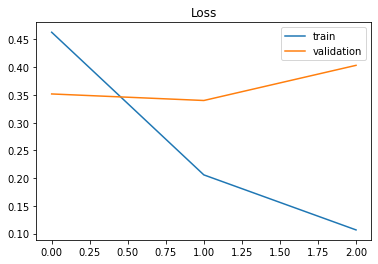

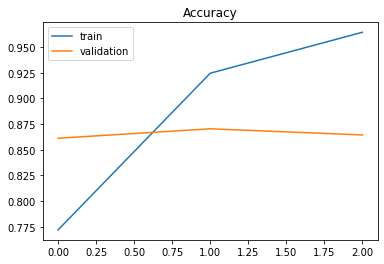

In [134]:
plt.title('Loss')
plt.plot(history.history.get('loss'), label='train')
plt.plot(history.history.get('val_loss'), label='validation')
plt.legend()
plt.show()

plt.title('Accuracy')
accuracy = history.history.get('accuracy') or history.history.get('acc')
val_accuracy = history.history.get('val_accuracy') or history.history.get('val_acc')
plt.plot(accuracy, label='train')
plt.plot(val_accuracy, label='validation')
plt.legend()
plt.show()

In [135]:
loss, accuracy = model.evaluate(test)

782/782 [==============================] - 38s 48ms/step - loss: 0.4922 - accuracy: 0.8368


## Predict

In [71]:
predictions = model.predict(test)

In [100]:
def convert_to_binary(value):
    return 1 if value > 0.5 else 0

y_hat = np.array(list(map(convert_to_binary, predictions)))
y_hat

array([1, 1, 0, ..., 0, 1, 1])

In [100]:
print(y_hat.shape)
print((y_hat != 0).sum())

(25000,)
12271


In [141]:
custom_input, _ = preprocess_input("I love this movie. Everything wasn't arranged and prepared", None)
custom_input = np.expand_dims(custom_input, axis=0)
p = model.predict(custom_input)
result = convert_to_binary(np.squeeze(p))
print(p)
print('positive' if result else 'negative')

[[0.47754273]]
negative
